In [1]:
# Load basic libraries
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textblob import TextBlob
import spacy
# !python -m spacy download en_core_web_sm

In [2]:
df = pd.read_excel("Data_Train.xlsx")
print(df.columns)
print(df.shape)

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price'],
      dtype='object')
(5699, 9)


In [3]:
df_test = pd.read_excel("test.xlsx")
print(df_test.columns)
print(df_test.shape)

Index(['Unnamed: 0', 'Title', 'Author', 'Edition', 'Reviews', 'Ratings',
       'Synopsis', 'Genre', 'BookCategory'],
      dtype='object')
(537, 9)


## Univariate Variable Analysis



In [4]:
df.describe()

,Price
count,5699.000000
mean,554.857428
std,674.363427
min,25.000000
25%,249.000000
50%,373.000000
75%,599.000000
max,14100.000000


In [5]:
df.describe(include=['object'])

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
count,5699,5699,5699,5699,5699,5699,5699,5699
unique,5130,3438,3183,36,333,5114,335,11
top,A Game of Thrones (A Song of Ice and Fire),Agatha Christie,"Paperback,– 5 Oct 2017",5.0 out of 5 stars,1 customer review,A Tinkle Double Digest is two Tinkle Digests i...,Action & Adventure (Books),Action & Adventure
freq,4,59,41,1257,947,7,868,750


In [6]:
df.head(3)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00


## Basic Data Analysis



<h4>Check for Duplicate Values</h4>

In [7]:
columns_to_check_duplicates = ['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Price']
duplicated = df.duplicated(subset=columns_to_check_duplicates, keep=False)
duplicate_rows = df[duplicated]

if not duplicate_rows.empty:
    print("Duplicate records found:")
    print(duplicated.sum())
else:
    print("No duplicate records found.")

Duplicate records found:
525


In [8]:
df_no_duplicates = df.drop_duplicates(subset=columns_to_check_duplicates, keep='first')
df = df_no_duplicates.reset_index(drop=True)
print("Dataframe with no duplicate values:")
print(df.shape)

Dataframe with no duplicate values:
(5434, 9)


<h4>Handle Null Values</h4>

In [9]:
null_counts = df.isnull().sum()
null_table = pd.DataFrame(null_counts, columns=["Null Count"])
null_table

,Null Count
Title,0
Author,0
Edition,0
Reviews,0
Ratings,0
Synopsis,0
Genre,0
BookCategory,0
Price,0


<h4>Detect Outliers</h4>
Identify outliers using the Z-score method

In [10]:
z_scores = pd.DataFrame(zscore(df['Price']), columns=['Price'])

threshold = 2
outliers = df[(z_scores.abs() > threshold).any(axis=1)]

print("Outlier records:")
print(outliers.shape)

Outlier records:
(164, 9)


In [11]:
df_with_outlier = df.copy()
df = df[(z_scores.abs() < threshold).all(axis=1)].reset_index(drop=True)

print("DataFrame without outliers:")
print(df.shape)

DataFrame without outliers:
(5270, 9)


<h4>Combine Datasets</h4>

In [12]:
# Test Dataset: df[5270:]
df_train = df.copy()
df_test.drop(columns=['Unnamed: 0'], inplace=True)

df = pd.concat([df_train, df_test])
df.reset_index(drop=True, inplace=True)
df

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62
...,...,...,...,...,...,...,...,...,...
5802,Humans: A Brief History of How We F*cked It Al...,Tom Phillips,"Paperback,– 8 Aug 2018",5.0 out of 5 stars,2 customer reviews,'F*cking brilliant' Sarah Knight\n'Very funny'...,Anthropology (Books),Humour,NaN
5803,The Chemist,Stephenie Meyer,"Paperback,– 21 Nov 2016",3.3 out of 5 stars,9 customer reviews,"In this gripping page-turner, an ex-agent on t...",Contemporary Fiction (Books),"Crime, Thriller & Mystery",NaN
5804,The Duke And I: Number 1 in series (Bridgerton...,Julia Quinn,"Paperback,– 8 Jun 2006",3.8 out of 5 stars,3 customer reviews,'The most refreshing and radiant love story yo...,Romance (Books),Romance,NaN
5805,Frostfire (Kanin Chronicles),Amanda Hocking,"Paperback,– 15 Jan 2015",3.5 out of 5 stars,4 customer reviews,Frostfire by Amanda Hocking is the stunning fi...,Action & Adventure (Books),Action & Adventure,NaN


<h4>Delete Unnecessary Text

In [13]:
df['Reviews'] = df['Reviews'].str[:3].astype(float)
df['Ratings'] = df['Ratings'].str.extract('(\\d+)').astype(int)
df.head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93


In [14]:
print("Unique Authors: " + str(df['Author'].nunique()))
print("Unique Titles: " + str(df['Title'].nunique()))

Unique Authors: 3556
Unique Titles: 5415


In [15]:
df['Title'] = df['Title'].str.replace('[^a-zA-Z0-9]', '', regex=True).str.lower()
df['Author'] = df['Author'].str.replace('[^a-zA-Z0-9]', '', regex=True).str.lower()
df.head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,theprisonersgoldthehunters3,chriskuzneski,"Paperback,– 10 Mar 2016",4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,guruduttatragedyinthreeacts,arunkhopkar,"Paperback,– 7 Nov 2012",3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93


In [16]:
print("Unique Authors: " + str(df['Author'].nunique()))
print("Unique Titles: " + str(df['Title'].nunique()))

Unique Authors: 3522
Unique Titles: 5408



## Feature Engineering



<h4>Genrate new features</h4>

In [17]:
df['CoverType'] = df['Edition'].str.split(',').str[0]
df['CoverType'].nunique()

18

In [18]:
df['Year'] = df['Edition'].str.split(' ').str[-1]
df['Year'].nunique()

63

<h4>Utilize NLP to extract Keywords and Sentiment</h4>

In [19]:
df['Synopsis'] = df['Synopsis'].str.lower()

In [20]:
df["Polarity"] =  df['Synopsis'].apply(lambda x: TextBlob(x).sentiment.polarity)
df["Subjectivity"] = df['Synopsis'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [48]:
nlp = spacy.load("en_core_web_sm")

# Function to extract keywords from Synopsis using SpaCy
def extract_keywords(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop and token.is_alpha]

df['Keywords'] = df['Synopsis'].apply(extract_keywords)
df['Keywords'] = df['Keywords'].apply(lambda x: ' '.join(x))


In [21]:
df.head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,CoverType,Year,Polarity,Subjectivity
0,theprisonersgoldthehunters3,chriskuzneski,"Paperback,– 10 Mar 2016",4.0,8,the hunters return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016,0.208800,0.451340
1,guruduttatragedyinthreeacts,arunkhopkar,"Paperback,– 7 Nov 2012",3.9,14,a layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012,0.183471,0.522176


<h2>Visualization</h2>

In [52]:
df_train = df[:5270]

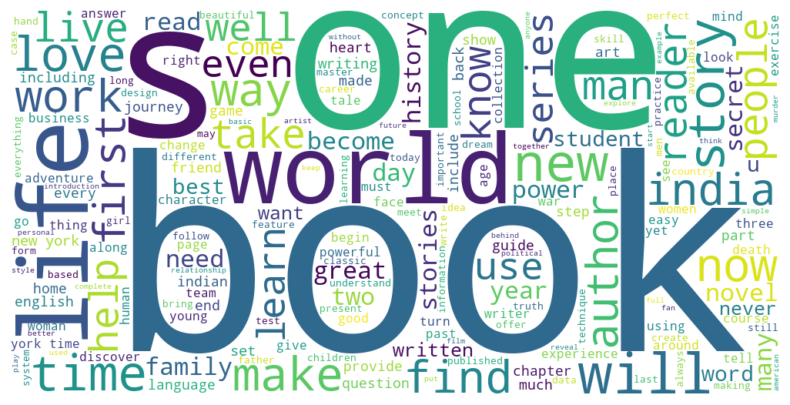

In [132]:
# Generate WordCloud based on synopsis
text_corpus = ' '.join(df_train['Synopsis'])
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


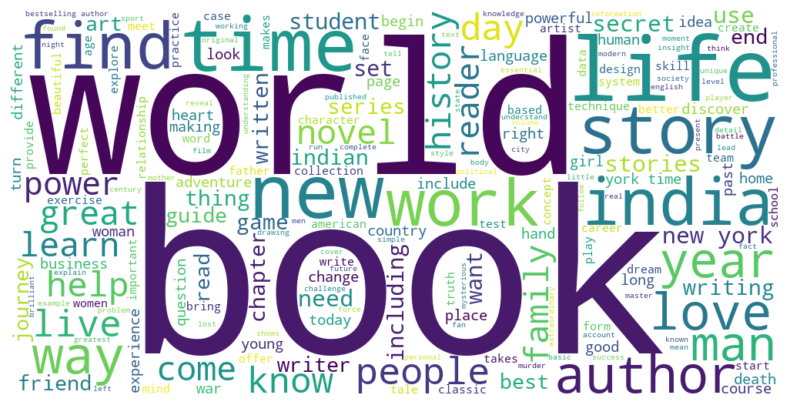

In [133]:
# Generate WordCloud based on Keywords
text_corpus = ' '.join(df_train['Keywords'])
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


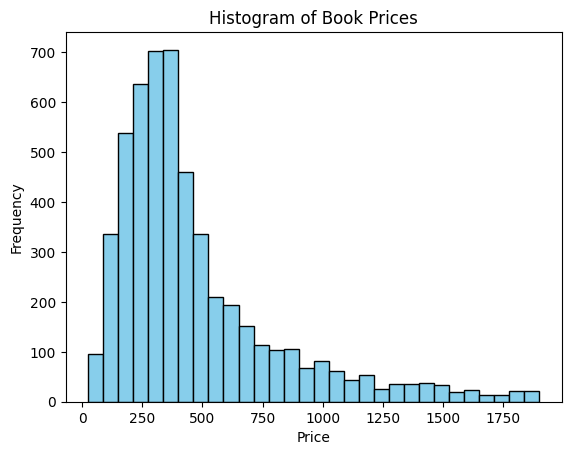

In [68]:
df_train["Price"].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

plt.title('Histogram of Book Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

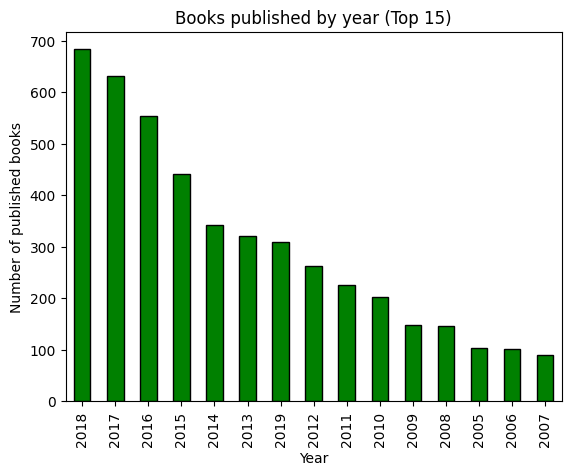

In [86]:
df_train['Year'].value_counts().head(15).plot(kind='bar', color='green', edgecolor='black')

plt.title('Books published by year (Top 15)')
plt.ylabel('Number of published books')
plt.xlabel('Year')
plt.show()

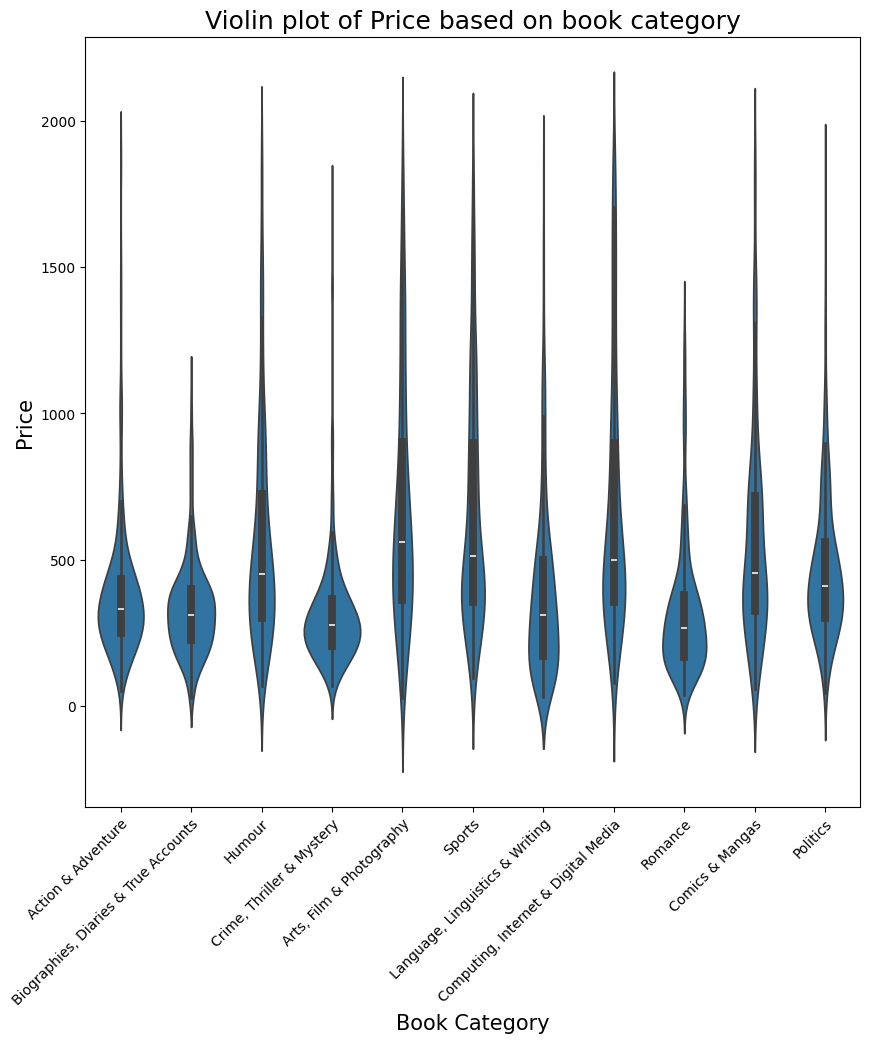

In [103]:
plt.figure(figsize=(10,10))
sns.violinplot(x=df['BookCategory'], y=df['Price'])

plt.title("Violin plot of Price based on book category", fontsize=18)
plt.xlabel("Book Category", fontsize=15)
plt.ylabel("Price", fontsize=15)

plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  
plt.show()

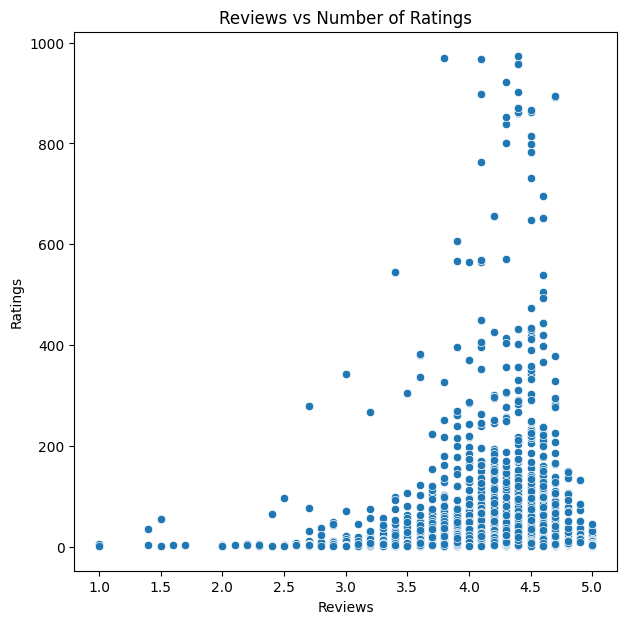

In [146]:
plt.figure(figsize=[7,7])
ax = sns.scatterplot(y='Ratings',
                x='Reviews',
                data=df_train)
ax.set_title('Reviews vs Number of Ratings')
plt.show()

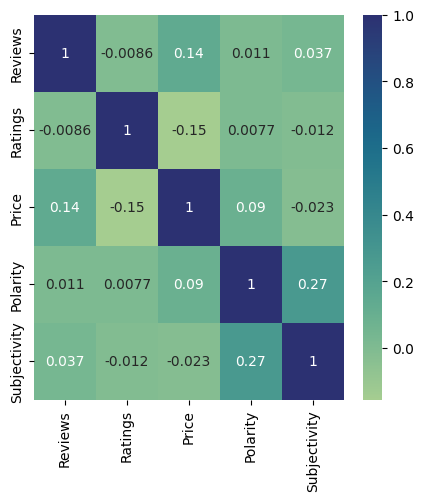

In [150]:
plt.figure(figsize=(5,5))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='crest')
plt.show()

## Feature transformation

In [134]:
# Use TF-IDF Vectorizer for Keywords
tfidf_vectorizer_synopsis = TfidfVectorizer()
tfidf_matrix_synopsis = tfidf_vectorizer_synopsis.fit_transform(df['Keywords'])

n_components = 50
pca = PCA(n_components=n_components)
tfidf_matrix_synopsis = pca.fit_transform(tfidf_matrix_synopsis.toarray())

In [135]:
# Use One-hot encoding for Author
encoded_author = pd.get_dummies(df['Author'], columns=['Author'], prefix='Author')
pca = PCA(n_components=20)
encoded_author = pca.fit_transform(encoded_author)

# Use One-hot encoding for CoverType
encoded_cover = pd.get_dummies(df['CoverType'], columns=['CoverType'], prefix='CoverType')
pca = PCA(n_components=10)
encoded_cover = pca.fit_transform(encoded_cover)

# Use One-hot encoding for BookCategory
encoded_category = pd.get_dummies(df['BookCategory'], columns=['BookCategory'], prefix='BookCategory')

In [136]:
# Combine all numerical features
combined_features = pd.concat([
    df[['Reviews', 'Ratings', 'Year', 'Polarity', 'Subjectivity']],
    pd.DataFrame(tfidf_matrix_synopsis),
    pd.DataFrame(encoded_author),
    pd.DataFrame(encoded_cover),
    encoded_category
    ], axis=1)

In [137]:
def convert_to_numeric(column):
    return pd.to_numeric(column, errors='coerce')

combined_features = combined_features.apply(convert_to_numeric)
combined_features.columns = combined_features.columns.astype(str)

combined_features.fillna(0, inplace=True)

In [138]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=2)
# X_poly = poly.fit_transform(combined_features)

## Modeling

Do not change this part of the code only run it!

In [139]:
def train(X_train, y_train, X_test, y_test):
    """
    Trains a RandomForestRegressor model and evaluates its performance using the mean squared error (MSE).

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): The training data with (n_rows, n_features) shape.
    y (numpy.ndarray or pandas.Series): The target variable (n_rows, 1) shape.

    Returns:
    float: The mean squared error (MSE) of the predictions(train data) made by the RandomForestRegressor.
    float: The mean squared error (MSE) of the predictions(test data) made by the RandomForestRegressor.
    """
    random_forest_regressor = RandomForestRegressor(criterion='squared_error')
    random_forest_regressor.fit(X_train, y_train)
    mse_train = random_forest_regressor.score(X_train, y_train)
    
    y_pred = random_forest_regressor.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred)

    return mse_train, mse_test

In [140]:
X_train, X_test, y_train, y_test = train_test_split(combined_features[:5270], df[:5270]['Price'], test_size=0.2, random_state=42)

In [141]:
mse_train, mse_test = train(X_train=X_train , y_train=y_train , X_test=X_test , y_test=y_test)
print("Train mse is: {} // Test mse is: {}".format(mse_train,mse_test))

Train mse is: 0.9098845944529949 // Test mse is: 75413.49964520245


<h4>Predict Prices based on test data</h4>

In [142]:
random_forest_regressor = RandomForestRegressor(criterion='squared_error')
random_forest_regressor.fit(combined_features[:5270], df['Price'][:5270])
prediction = random_forest_regressor.predict(combined_features[5270:])

In [143]:
prediction_df = pd.DataFrame(prediction).reset_index()
prediction_df.rename(columns={0: 'Price'}, inplace=True)
prediction_df.head()

,index,Price
0,0,436.550600
1,1,415.157187
2,2,318.443800
3,3,407.018000
4,4,491.826500


In [144]:
prediction_df.to_csv('Mahan Madani - Prediction.csv', index=False)

## Post processing

Error Analysis: Analyzing the model's errors on the test data can provide valuable insights into its strengths and weaknesses. This involves identifying common error patterns, understanding the causes of errors, and exploring strategies to mitigate them.

Feature Importance Analysis: Identifying the most important features contributing to the model's predictions can help in feature selection and dimensionality reduction. This can lead to a more efficient and interpretable preprocessing pipeline.

In [115]:
# Use feature importances for feature selection
feature_selector = SelectFromModel(random_forest_regressor, threshold='median')
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_test_selected = feature_selector.transform(X_test)

In [118]:
mse_train, mse_test = train(X_train=X_train , y_train=y_train , X_test=X_test , y_test=y_test)
print("Train mse is: {} // Test mse is: {}".format(mse_train,mse_test))

Train mse is: 0.9090251828562514 // Test mse is: 78095.46905065904


In [121]:
# Use feature importances for feature selection
feature_selector = SelectFromModel(random_forest_regressor, threshold='median')
selected_df = feature_selector.fit_transform(combined_features[:5270], df['Price'][:5270])

In [122]:
random_forest_regressor = RandomForestRegressor(criterion='squared_error')
random_forest_regressor.fit(combined_features[:5270], df['Price'][:5270])
prediction = random_forest_regressor.predict(combined_features[5270:])

prediction_df = pd.DataFrame(prediction).reset_index()
prediction_df.rename(columns={0: 'Price'}, inplace=True)
prediction_df.head()

prediction_df.to_csv('Mahan Madani - Prediction_enhanced.csv', index=False)